## baseline

## パッケージインポート

In [88]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade pip
!pip install xfeat
!pip install japanize_matplotlib
!pip install tensorflow_text
!pip install transformers
!pip install googletrans==4.0.0-rc1
!pip install fasttext

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
!nvidia-smi

Wed May  4 06:07:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   2838MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [90]:
## データ処理
import pandas as pd
import numpy as np
import math
import gc
import random
import re
from datetime import datetime as dt
import time
from xfeat import (ArithmeticCombinations, ConcatCombination,
                   GBDTFeatureExplorer, GBDTFeatureSelector, LabelEncoder,
                   LambdaEncoder, Pipeline, SelectCategorical, SelectNumerical,
                   TargetEncoder, aggregation)
from geopy.distance import geodesic
from joblib import Parallel, delayed
from pathlib import Path
from sklearn import mixture
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

## 自然言語処理
from sklearn.decomposition import (
    PCA,
    TruncatedSVD,
    NMF,
    LatentDirichletAllocation, 
)
from sklearn.pipeline import (
    make_pipeline, 
    make_union
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)
from googletrans import Translator

import fasttext
import fasttext.util

## 可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import japanize_matplotlib
from tqdm import tqdm


## モデル
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from tensorflow import keras
from numba import cuda

import torch
import transformers
from transformers import BertTokenizer

# import optuna.integration.lightgbm as lgb

## 評価
from sklearn.metrics import mean_squared_error

## 実行に関係ない警告を無視
import warnings 
warnings.filterwarnings('ignore')

## DataFrame display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## SEED
SEED = 3
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterinistic = True

In [91]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## データ読み込み

In [92]:
INPUT = './drive/MyDrive/Colab Notebooks/stay/Input/'
OUTPUT = './drive/MyDrive/Colab Notebooks/stay/Output/'
train = pd.read_csv(INPUT + '/train_data.csv')
test = pd.read_csv(INPUT + '/test_data.csv')
station = pd.read_csv(INPUT + '/station_list.csv')

train_station = pd.read_csv(INPUT + '/nearest_train_station.csv')
test_station = pd.read_csv(INPUT + '/nearest_test_station.csv')

## 特徴量追加関数定義

In [93]:
## ゴールデンウィークの時期04-25 - 04-30
def golden_week(date):
    goolden_week_flg = False

    if date == date:
        month = int(dt.datetime.strptime(date, '%Y-%m-%d').month)
        day = int(dt.datetime.strptime(date, '%Y-%m-%d').day)

        # 4月
        if (month == 4) & ((25 <= day) & (day <= 30)):
            goolden_week_flg = True

        # 5月
        if (month == 5) & ((1 <= day) & (day <= 6)):
            goolden_week_flg = True
    
    return goolden_week_flg

# # 最寄り駅の名称、距離追加
# def add_station_helper(df, ids):
#     nearest_list = []
#     station_distance_list = (station['latitude'], station['longitude'])
#     for index in tqdm(ids):
#         row = df.iloc[index]
#         row_distance = (row['latitude'], row['longitude'])
#         dist_list = []
#         for id, r in station.iterrows():
#             station_distance = station_distance_list[0][id], station_distance_list[1][id]
#             dis = geodesic(row_distance, station_distance).km
#             dist_list.append({
#                 'station_name':r['station_name'], 
#                 'distance':dis, 
#                 'latitude':r['latitude'], 
#                 'longitude':r['longitude']
#             })
        
#         station_dist_df = pd.DataFrame(dist_list)
#         station_dist_df = station_dist_df.sort_values('distance').iloc[0]
#         nearest_station_name = station_dist_df['station_name']
#         nearest_latitude = station_dist_df['latitude']
#         nearest_longitude = station_dist_df['longitude']
#         distance = station_dist_df['distance']

#         dist_under_001_count = (station_dist_df['distance'] < 0.1).sum()
#         dist_under_005_count = (station_dist_df['distance'] < 0.5).sum()
#         dist_under_01_count = (station_dist_df['distance'] < 1.0).sum()

#         nearest_list.append({
#             'id':row['id'],
#             'station_name': nearest_station_name,
#             'distance': distance,
#             'station_latitude': nearest_latitude, 
#             'station_longitude': nearest_longitude, 
#             'dist_under_001_count': dist_under_001_count,
#             'dist_under_005_count': dist_under_005_count,
#             'dist_under_01_count': dist_under_01_count,
#         })

#     return nearest_list

# def add_station(df):
#     training_samples = []
#     testing_samples = []
    
#     train_df = df[df['class'] == 0]
#     test_df = df[df['class'] == 1]

#     train_ids = train_df["id"].unique()
#     test_ids = test_df["id"].unique()

#     train_ids = train_ids - 1
#     test_ids = test_ids - 1

#     train_ids_splits = np.array_split(train_ids, 8)
#     test_ids_splits = np.array_split(test_ids, 8)

#     # train
#     train_results = Parallel(n_jobs=8, backend='multiprocessing')(
#         delayed(add_station_helper)(train_df, idx) for idx in train_ids_splits
#     )
#     for result in train_results:
#         training_samples.extend(result)

#     # test
#     test_results = Parallel(n_jobs=8, backend='multiprocessing')(
#         delayed(add_station_helper)(test_df, idx) for idx in test_ids_splits
#     )
#     for result in test_results:
#         testing_samples.extend(result)

#     train_df = pd.merge(train_df, pd.DataFrame(training_samples), how='left', on='id')
#     test_df = pd.merge(test_df, pd.DataFrame(testing_samples), how='left', on='id')

#     df = train_df.append(test_df)

#     return df

def add_station(df):

    train_df = df[df['class'] == 0]
    test_df = df[df['class'] == 1]

    train_df = pd.merge(train_df, train_station, on='id', how='left')
    test_df = pd.merge(test_df, test_station, on='id', how='left')

    df = train_df.append(test_df)

    return df

# 地域ごとのレビュー信頼度
def neighbourhood_review(df):
    review_st = pd.DataFrame(columns=['neighbourhood', 'number_of_reviews', 'reviews_st_scaler'])

    for row in df.groupby('neighbourhood'):
        sc_df = row[1][['neighbourhood', 'number_of_reviews']]

        sc = StandardScaler()
        sc.fit(sc_df[['number_of_reviews']])
        sc_df['reviews_st_scaler'] = sc.transform(sc_df[['number_of_reviews']])
        sc_df = sc_df.drop_duplicates()
        review_st = review_st.append(sc_df)

    df = pd.merge(df, review_st, how='left', on=['neighbourhood', 'number_of_reviews'])
    return df

# 重心からの距離
def centroid(df):
    lat = df['latitude'].mean()
    long = df['longitude'].mean()

    centroid = (lat, long)

    centroid_dist = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        a = np.array([row['latitude'], row['longitude']])
        centroid_dist.append(np.linalg.norm(a - centroid))

    df['centroid_dist'] = centroid_dist

    return df

# availability, number_of_reviewsが0
def non_ava(row):
    return row['availability_365'] == 0 and row['number_of_reviews'] == 0

In [94]:
### text関連
# bert
def add_bert(df):
    %%time
    BSV = BertSequenceVectorizer(model_name="bert-base-multilingual-uncased", max_len=128)
    features = np.stack(df["name"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

    pca = PCA(n_components=20, random_state=SEED)
    pca_features = pca.fit_transform(features)

    df = pd.concat([df, pd.DataFrame(pca_features).add_prefix('BERT_')], axis=1)
    return df


# GMM
def gmm(df):
    clf = mixture.GaussianMixture(n_components=30, covariance_type='full')
    gm = clf.fit_predict(df[['latitude','longitude', 'room_type']])

    df['gmm'] = gm
    return df



# people
def people(name):
    people = np.nan
    if ('ppl' in name.lower() or 'people' in name.lower()):
        people_str = re.search('[0-9]+(| )(ppl|people)', name)
        if people_str != None:
            people = re.sub(r'\D', '', people_str.group())

    else:
        if ('max' in name.lower()):
            people_str = re.search('max(| )[0-9]+', name)
            if people_str != None:
                people = re.sub(r'\D', '', people_str.group())

    return people


# ㎡
def area(name):
    area = np.nan
    if ('㎡' in name.lower()):
        area_str = re.search('[0-9]+(| )(㎡)', name)
        if area_str != None:
            area = re.sub(r'\D', '', area_str.group())
    
    else:
        if ('sqm' in name.lower()):
            area_str = re.search('[0-9]+(| )(sqm)', name)
            if area_str != None:
                area = re.sub(r'\D', '', area_str.group())
    return area

# %off
def per_off(name):
    off = np.nan
    if ('%' in name.lower()):
        off_str = re.search('[0-9]+(| )(%)', name)
        if off_str != None:
            off = re.sub(r'\D', '', off_str.group())

    return off

# 階層
def floor(name):
    floor = np.nan
    if ('F' in name):
        off_str = re.search('[0-9]+(| )(F)', name)
        if off_str != None:
            floor = re.sub(r'\D', '', off_str.group())

    return floor

# use
def use(df):
    tqdm.pandas()

    embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
    features = np.stack(df["name"].fillna("").progress_apply(lambda x: embedder(x).numpy().reshape(-1)).values)
    svd = TruncatedSVD(n_components=30, random_state=SEED)
    svd_features = svd.fit_transform(features)

    df = pd.concat([df, pd.DataFrame(svd_features[:len(df)]).add_prefix('USE_')], axis=1)
    return df

# tfidf
def get_sequence_tfidf(input_df, col, n_comp):
    vectorizer = make_pipeline(
        TfidfVectorizer(),
        make_union(
            TruncatedSVD(n_components=n_comp, random_state=SEED),
            NMF(n_components=min(n_comp, 10), random_state=SEED),
        n_jobs=1)
    )
    sequences = input_df[col]
    X = vectorizer.fit_transform(sequences).astype(np.float32)
    cols = (
        [f'{col}_tfidf_svd_{i}' for i in range(n_comp)]
        + [f'{col}_tfidf_nmf_{i}' for i in range(min(n_comp, 10))]
    )
    output_df = pd.DataFrame(X, columns=cols)
    return output_df


# 単語関連の特徴量追加
def add_word(df):
    df['is_wifi'] = df['name'].apply(lambda x : 'wi-fi' in x.lower() or 'wifi' in x.lower())
    df['is_free'] = df['name'].apply(lambda x : 'free' in x.lower())
    df['is_min'] = df['name'].apply(lambda x : 'min ' in x.lower() or 'minutes' in x.lower() or 'minute' in x.lower())
    df['is_airport'] = df['name'].apply(lambda x : 'airport' in x.lower())
    df['is_star'] = df['name'].apply(lambda x : '★' in x.lower() or '☆' in x.lower())
    df['is_uhome'] = df['name'].apply(lambda x : 'uhome' in x.lower())
    df['is_roppongi'] = df['name'].apply(lambda x : 'roppongi' in x.lower())
    df['is_modern'] = df['name'].apply(lambda x : 'modern' in x.lower())
    df['is_suite'] = df['name'].apply(lambda x : 'suite' in x.lower())

    df['is_sale'] = df['name'].apply(lambda x : 'sale' in x.lower())
    
    return df

# sex
def sex(df):

    df['female'] = df['name'].apply(lambda x : 1 if 'female' in x.lower() else 0)
    df['male'] = train['name'].apply(lambda x : 2 if ('female' not in x.lower()) & ('male' in x.lower()) else 0)

    df['sex'] = df['male'] + df['female']
    df = df.drop(['male', 'female'], axis=1)

    return df

# room_num
def room_num(df):

    df['single'] = df['name'].apply(lambda x : 1 if 'single' in x.lower() else 0)
    df['semi'] = df['name'].apply(lambda x : 0.5 if 'semi' in x.lower() else 0)
    df['double'] = df['name'].apply(lambda x : 2 if 'double' in x.lower() else 0)
    df['twin'] = df['name'].apply(lambda x : 3 if 'twin' in x.lower() else 0)
    df['triple'] = df['name'].apply(lambda x : 4 if 'triple' in x.lower() else 0)
    df['quad'] = df['name'].apply(lambda x : 5 if 'Quad' in x.lower() else 0)

    df['room_num'] = df['single'] + df['semi'] + df['double'] + df['twin'] + df['triple'] + df['quad']

    df = df.drop(['single', 'double', 'semi', 'twin', 'triple', 'quad'], axis=1)

    return df

# fasttext
def add_fast_text(df):
    fasttext.util.download_model('en', if_exists='ignore')
    ft_model = fasttext.load_model('cc.en.300.bin')

    features = np.stack(df["name"].fillna("").str.replace("\n", "").map(lambda x: ft_model.get_sentence_vector(x)).values)
    svd = TruncatedSVD(n_components=50, random_state=SEED)
    svd_features = svd.fit_transform(features)

    df = pd.concat([df, pd.DataFrame(svd_features[:len(df)]).add_prefix('FAST_')], axis=1)

    return df

In [95]:
def add_feature(df):
    
    # 日付変換
    df['year'] = pd.to_datetime(df['last_review']).dt.year
    df['month'] = pd.to_datetime(df['last_review']).dt.month
    df['day'] = pd.to_datetime(df['last_review']).dt.day
    # df['golden_week'] = df['last_review'].apply(lambda x: golden_week(x))

    # 地域ごとのレビュー信用度
    df = neighbourhood_review(df)

    # レビュー数を対数化
    # df['number_of_reviews'] = df['number_of_reviews'].apply(lambda x: np.exp(x))

    # # レビューがあった月数
    df['number_reviews_month'] = df['number_of_reviews'] / df['reviews_per_month']
    
    # # 最寄り駅情報追加
    df = add_station(df)

    # # 地域ごとの平均宿泊可能日数
    a = df.groupby(['station_name']).mean().reset_index()[['station_name', 'availability_365']]
    a.columns = ['station_name', 'mean_sta_ava']
    df = pd.merge(df, a, how='left', on='station_name')

    # 日本語->英語
    df = convert_transrate(df)

    df['name'] = df['name'].apply(lambda x : ' '.join(x.split('/')))
    df['name'] = df['name'].apply(lambda x : ' '.join(x.split('|')))
    df['word_count'] = df['name'].apply(lambda x : len(x.split()))
    df['name_len'] = df['name'].apply(lambda x : len(x))

    # # 関連ある単語追加
    df = add_word(df)

    # # people
    df['people'] = df['name'].apply(lambda x: people(x))
    df['people'] = df['people'].astype('float')

    # # area
    df['area'] = df['name'].apply(lambda x: area(x))
    df['area'] = df['area'].astype('float')

    # # %off
    df['per_off'] = df['name'].apply(lambda x: per_off(x))
    df['per_off'] = df['per_off'].astype('float')

    # # floor
    df['floor'] = df['name'].apply(lambda x: floor(x))
    df['floor'] = df['floor'].astype('float')

    # ava0
    # df['non_ava'] = df.apply(non_ava, axis=1)

    # room_num
    df = room_num(df)



    # # TF IDS
    tf_ids = get_sequence_tfidf(df, 'name', 32)
    df = pd.concat([df.reset_index(drop=True), tf_ids], axis=1)  

    df['room_type_neibourhood'] = df['room_type'] + df['neighbourhood']
    df['room_min'] = df['room_type'] + df['minimum_nights'].astype(str)

    # # frequency encoding
    # count_col = [
    #     'station_name',
    #     'neighbourhood', 
    #     'number_of_reviews'
    # ]
    # for col in count_col:
    #     summary = df[col].value_counts()
    #     df[col + '_count'] = df[col].map(summary)

    
    # one hot encoding
    # df = pd.get_dummies(df, columns=['room_type_neibourhood'])
    # df = pd.get_dummies(df, columns=["room_type"])
    host_nei = df[['neighbourhood', 'host_id', 'class']]
    # df = pd.get_dummies(df, columns=["neighbourhood"])
    # df = pd.get_dummies(df, columns=["minimum_nights"])
    # df = pd.get_dummies(df, columns=["station_name"])

    # # use
    df = use(df)

    # # fasttext
    # df = add_fast_text(df)

    # # BERT
    df = add_bert(df)

    ## label encoding 
    # 数値データを抽出しておく
    num_df = SelectNumerical().fit_transform(df)

    # カテゴリデータを選んで、label encoding を実行するパイプラインを定義
    encoder = Pipeline([
        SelectCategorical(),
        LabelEncoder(output_suffix=""),
    ])
    # label encoding を実行
    le_df = encoder.fit_transform(df)

    # 数値型のデータとlabel encoding されたデータを結合して元に戻す
    df = pd.concat([num_df, le_df], axis=1)

    # # GMM
    df = gmm(df)
    df = df.reset_index(drop=True)
    # # target encoding
    df = target_encoding(df)


    df = centroid(df)

    # 不要な列削除
    df.drop(['name', 'last_review', 'room_type_neibourhood', 'gmm', 'dist_under_01_count', 'room_min'], axis=1, inplace=True)

    return df, host_nei

## ターゲットエンコーディング

In [96]:
def target_encoding(df):
    col = ['gmm', 'room_type_neibourhood', 'room_min']

    ts = pd.Series(np.empty(df.shape[0]), index=df.index)
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    for c in col:
        for _, holdout_idx in folds.split(df, df[c]):
            agg_df = df.groupby(c).agg({'y': ['sum', 'count']})
            # ホールドアウトする行を取り出す
            holdout_df = df.iloc[holdout_idx]
            # ホールドアウトしたデータで合計とカウントを計算する
            holdout_agg_df = holdout_df.groupby(c).agg({'y': ['sum', 'count']})
            # 全体の集計からホールドアウトした分を引く
            train_agg_df = agg_df - holdout_agg_df
            # ホールドアウトしたデータの平均値を計算していく
            oof_ts = holdout_df.apply(lambda row: train_agg_df.loc[row[c]][('y', 'sum')] \
                                                  / (train_agg_df.loc[row[c]][('y', 'count')]) + 1, axis=1)

            # 生成した特徴量を記録する
            ts[oof_ts.index] = oof_ts

        ts.name = c + '_ts'
        df = df.join(ts)

    return df

## BERT

In [97]:
class BertSequenceVectorizer:
    def __init__(self, model_name="bert-base-uncased", max_len=128):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = max_len

    def vectorize(self, sentence: str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

## 外れ値除去

In [98]:
def remove(df):
    df = df[df['id'] != 4360]
    # df = df[df['number_of_reviews'] <= 450]

    # 年初特价のデータ削除
    # df = df[~df['name'].str.contains('年初特价')]
    return df

## 翻訳

In [99]:
# trans_train = pd.read_excel(INPUT + 'trans_result_train.xlsx')
# trans_train.columns = ['id', 'trans_name']
# train = pd.merge(train, trans_train, on='id', how='left')
# train['trans_name'] = train[['name', 'trans_name']].apply(lambda x: str(x[1]) if str(x[1]) != 'nan' else str(x[0]), axis=1)
# train.drop(['name'], axis=1, inplace=True)
# train = train.rename(columns={'trans_name': 'name'})

# trans_test = pd.read_excel(INPUT + 'trans_result_test.xlsx')
# trans_test.columns = ['id', 'trans_name']
# test = pd.merge(test, trans_test, on='id', how='left')
# test['trans_name'] = test[['name', 'trans_name']].apply(lambda x: str(x[1]) if str(x[1]) != 'nan' else str(x[0]), axis=1)
# test.drop(['name'], axis=1, inplace=True)
# test = test.rename(columns={'trans_name': 'name'})

In [100]:
def convert_transrate(df):
    neighbourhood_jp = ['江東', '台東', '葛飾', '渋谷', '新宿', '荒川', '豊島', '大田', '世田谷', '北', '江戸川', '中央', 
                        '港', '品川', '墨田', '中野', '杉並', '板橋', '千代田', '足立', '目黒', '文京', '練馬']
    neighbourhood_en = ['Koto ', 'Taito ', 'Katsushika ', 'Shibuya ', 'Shinjuku ', 'Arakawa ', 'Toshima ', 'Ota ', 'Setagaya ',
       'Kita ', 'Edogawa ', 'Chuo ', 'Minato ', 'Shinagawa ', 'Sumida ', 'Nakano ', 'Suginami ', 'Itabashi ', 'Chiyoda ', 'Adachi ', 'Meguro ', 'Bunkyo ', 'Nerima ']

    neighbourhood = [neighbourhood_jp, neighbourhood_en]
    
    for idx in np.arange(len(neighbourhood_jp)):
        df['name'] = df['name'].replace(neighbourhood_jp[idx], neighbourhood_en[idx], regex=True)


    df['name'] = df['name'].replace('駅', 'station ', regex=True)
    df['name'] = df['name'].replace('東京', 'Tokyo ', regex=True)
    df['name'] = df['name'].replace('家族', 'family ', regex=True)
    df['name'] = df['name'].replace('友達', 'friends ', regex=True)
    df['name'] = df['name'].replace('カップル', 'couple ', regex=True)
    df['name'] = df['name'].replace('男性', 'men ', regex=True)
    df['name'] = df['name'].replace('女性', 'women ', regex=True)
    df['name'] = df['name'].replace('最大', 'max ', regex=True)
    df['name'] = df['name'].replace('立地', 'location ', regex=True)
    df['name'] = df['name'].replace('銀座', 'Ginza ', regex=True)
    df['name'] = df['name'].replace('徒歩', 'on foo, regex=Truet ')
    df['name'] = df['name'].replace('歩', 'on foo, regex=Truet ')
    df['name'] = df['name'].replace('専用', 'exclusive ', regex=True)
    df['name'] = df['name'].replace('電車', 'train ', regex=True)
    df['name'] = df['name'].replace('分', 'mins ', regex=True)
    df['name'] = df['name'].replace('アクセス', 'access ', regex=True)
    df['name'] = df['name'].replace('成田', 'Narita ', regex=True)
    df['name'] = df['name'].replace('羽田', 'Haneda ', regex=True)
    df['name'] = df['name'].replace('空港', 'Airport ', regex=True)
    df['name'] = df['name'].replace('交通', 'transportation ', regex=True)
    df['name'] = df['name'].replace('雷門', 'Kaminarimon ', regex=True)
    df['name'] = df['name'].replace('池袋', 'Ikebukuro ', regex=True)
    df['name'] = df['name'].replace('浅草', 'Asakusa ', regex=True)
    df['name'] = df['name'].replace('寺', 'temple ', regex=True)

    df['name'] = df['name'].replace('六本木', 'Roppongi ', regex=True)

    df['name'] = df['name'].replace('PPL', 'ppl', regex=True)
    df['name'] = df['name'].replace('PEOPLE', 'people', regex=True)
    df['name'] = df['name'].replace('People', 'people', regex=True)
    # df['name'] = df['name'].replace('名', 'people ', regex=True)

    df['name'] = df['name'].replace('three', '3', regex=True)
    df['name'] = df['name'].replace('有人家', 'Uhome ', regex=True)

    df['name'] = df['name'].replace('Max', 'max', regex=True)
    df['name'] = df['name'].replace('MAX', 'max', regex=True)

    # df['name'] = df['name'].replace('階', 'F ', regex=True)

    return df

## 特徴量追加

In [101]:
uhome_mean = train[train['name'].str.contains('Uhome')]['y'].mean()
uhome_mean_log = np.round(np.log(uhome_mean), 4)

train['class'] = 0
test['class'] = 1

train['y'] = np.log(train["y"])

# 外れ値除去
train = remove(train)

# 特徴量追加
join_data = train.append(test)
join_data, host_nei = add_feature(join_data)

join_data = reduce_mem_usage(join_data)

train = join_data[join_data['class'] ==0]
train.drop(['class'], axis=1, inplace=True)

test_data = join_data[join_data['class'] ==1]
test = test_data.drop(['y', 'class', 'id', 'host_id'], axis=1)

100%|██████████| 14985/14985 [02:18<00:00, 108.40it/s]


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 14985/14985 [00:01<00:00, 10005.47it/s]


Memory usage of dataframe is 9.40 MB
Memory usage after optimization is: 3.86 MB
Decreased by 59.0%


In [102]:
print(train.shape)
train.head()

(9989, 136)


,id,host_id,latitude,longitude,minimum_nights,reviews_per_month,availability_365,y,year,month,day,reviews_st_scaler,distance,station_latitude,station_longitude,dist_under_001_count,dist_under_005_count,mean_sta_ava,word_count,name_len,is_wifi,is_free,is_min,is_airport,is_star,is_uhome,is_roppongi,is_modern,is_suite,is_sale,people,area,per_off,floor,room_num,name_tfidf_svd_0,name_tfidf_svd_1,name_tfidf_svd_2,name_tfidf_svd_3,name_tfidf_svd_4,name_tfidf_svd_5,name_tfidf_svd_6,name_tfidf_svd_7,name_tfidf_svd_8,name_tfidf_svd_9,name_tfidf_svd_10,name_tfidf_svd_11,name_tfidf_svd_12,name_tfidf_svd_13,name_tfidf_svd_14,name_tfidf_svd_15,name_tfidf_svd_16,name_tfidf_svd_17,name_tfidf_svd_18,name_tfidf_svd_19,name_tfidf_svd_20,name_tfidf_svd_21,name_tfidf_svd_22,name_tfidf_svd_23,name_tfidf_svd_24,name_tfidf_svd_25,name_tfidf_svd_26,name_tfidf_svd_27,name_tfidf_svd_28,name_tfidf_svd_29,name_tfidf_svd_30,name_tfidf_svd_31,name_tfidf_nmf_0,name_tfidf_nmf_1,name_tfidf_nmf_2,name_tfidf_nmf_3,name_tfidf_nmf_4,name_tfidf_nmf_5,name_tfidf_nmf_6,name_tfidf_nmf_7,name_tfidf_nmf_8,name_tfidf_nmf_9,USE_0,USE_1,USE_2,USE_3,USE_4,USE_5,USE_6,USE_7,USE_8,USE_9,USE_10,USE_11,USE_12,USE_13,USE_14,USE_15,USE_16,USE_17,USE_18,USE_19,USE_20,USE_21,USE_22,USE_23,USE_24,USE_25,USE_26,USE_27,USE_28,USE_29,BERT_0,BERT_1,BERT_2,BERT_3,BERT_4,BERT_5,BERT_6,BERT_7,BERT_8,BERT_9,BERT_10,BERT_11,BERT_12,BERT_13,BERT_14,BERT_15,BERT_16,BERT_17,BERT_18,BERT_19,neighbourhood,room_type,number_of_reviews,number_reviews_month,station_name,gmm_ts,room_type_neibourhood_ts,room_min_ts,centroid_dist
0,1,242899459,35.68750,139.750,1,2.210938,173,9.390625,2020.0,4.0,25.0,0.507324,0.385742,35.68750,139.750,0,1,126.5000,6,50,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,NaN,NaN,0.0,0.089905,0.029495,-0.027435,0.102844,-0.025162,0.093506,-0.035767,0.021957,-0.033173,0.029358,0.034912,0.033844,-0.010857,-0.014687,-0.049011,0.048889,0.036652,0.002451,0.009567,-0.018906,0.032471,0.025131,0.056488,-0.071411,0.085449,-0.049622,-0.003731,-0.000907,0.018784,-0.039673,-0.017670,-0.050507,0.000000,0.000000,0.025528,0.040588,0.000000,0.000000,0.000000,0.001092,0.00312,0.000000,0.591797,0.148071,0.062988,0.254639,0.196899,-0.054138,-0.124817,-0.088074,-0.140381,-0.228149,-0.006485,-0.085632,0.096680,-0.091370,0.076538,0.110107,0.040558,-0.077087,-0.084961,-0.042175,0.054871,0.095581,-0.131592,0.136230,-0.039612,-0.057770,-0.127075,0.003151,-0.130493,-0.064575,-0.319092,-0.128906,-0.110413,-0.099426,-0.244385,-0.447754,-0.256348,0.248901,0.026138,-0.079041,0.022263,0.086609,-0.029068,-0.170044,0.038300,-0.022781,-0.094849,0.118042,-0.001415,0.142578,0,0,0,0,0,10.835938,10.468750,10.781250,0.063904
1,2,308879948,35.71875,139.750,6,2.109375,9,8.804688,2020.0,3.0,25.0,1.256836,0.155396,35.71875,139.750,0,1,174.8750,6,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.151978,-0.087524,0.119629,0.078857,-0.030975,-0.094360,-0.030502,0.012970,0.014648,-0.004425,0.187012,0.005894,-0.033875,0.046295,0.052063,-0.008537,-0.096008,0.037659,-0.049438,-0.026123,-0.070435,-0.006969,-0.062744,0.031799,-0.002985,-0.019760,0.023438,-0.031555,0.043274,-0.066650,0.146851,0.043182,0.000000,0.069702,0.031403,0.000000,0.000000,0.000000,0.000000,0.050476,0.00000,0.000000,0.525879,-0.461426,-0.006916,0.076721,0.198364,-0.164062,-0.154053,0.010246,0.189087,0.061035,0.236450,-0.134888,-0.014145,0.052917,-0.083557,-0.016449,0.062256,0.106873,-0.065002,0.023819,-0.057770,-0.055603,0.000060,-0.005825,0.012466,0.076050,0.046387,-0.008995,-0.055328,0.002848,0.619629,0.804688,-0.187866,-0.008324,-0.363525,0.238525,-0.037079,-0.254395,0.186523,0.005325,0.225464,0.355225,0.166870,-0.184570,0.117615,-0.014702,0.144409,0.115173,0.197266,-0.162231,1,0,1,1,1,10.781250,10.789062,10.562500,0.048492
2,3,300877823,35.75000,139.875,1,3.460938,288,9.203125,2020.0,3.0,23.0,-0.077087,0.369629,35.75000,139.875,0,1,99.0000,4,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.183472,-0.015717,0.034943,-0.024

## LightGBMモデル作成

In [103]:
def create_lightgbm():
    return lgb.LGBMRegressor(
    boosting_type='gbdt', # 木を作るときのルール
    # boosting_type='dart', # 木を作るときのルール
    num_leaves=62, # 葉の数
    max_depth=-1, # 最大の深さ
    learning_rate=0.01, # 学習率
    n_estimators=20000, # 木を作る数
    subsample=0.7, # 学習に用いるデータの割合
    subsample_freq=1, # サンプリングを行う頻度
    lambda_l2=0.1, 
    colsample_bytree=0.7, # 学習に用いる列の割合
    objective="regression", # 対象とするのは回帰問題
    random_state=SEED, # 乱数シード
    silent=False, # 学習内容の表示
    importance_type='gain', # 変数の重要度の計算方法
    )

## データ分割

In [104]:
X = train.drop(["y", "host_id"], axis=1)
neighbourhood = host_nei[host_nei['class'] ==0]['neighbourhood']
host_id = host_nei[host_nei['class'] ==0]['host_id']
Y = train["y"]

In [105]:
sc = StandardScaler()

sc_train = train.drop(['y', 'host_id', 'y'], axis=1).copy()
train_ids = train['id']
sc_train = sc_train.replace([np.inf, -np.inf], np.nan)
sc_train = sc_train.fillna(0)
train_col = sc_train.columns

sc.fit(sc_train)
sc_train = pd.DataFrame(sc.transform(sc_train))
sc_train.columns = train_col
sc_train['id'] = train_ids
sc_Y = train['y']


sc = StandardScaler()

sc_test = test.copy()
sc_test = sc_test.replace([np.inf, -np.inf], np.nan)
sc_test = sc_test.fillna(0)
test_col = sc_test.columns


sc.fit(sc_test)
sc_test = pd.DataFrame(sc.transform(sc_test))
sc_test.columns = test_col


## 学習・予測

### LightGBM(StratifiedKFold)

=======================0=======================
train shape (7991, 133)
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.561743	valid_0's l2: 0.315555
[1000]	valid_0's rmse: 0.52856	valid_0's l2: 0.279376
[1500]	valid_0's rmse: 0.515789	valid_0's l2: 0.266038
[2000]	valid_0's rmse: 0.509977	valid_0's l2: 0.260077
[2500]	valid_0's rmse: 0.507082	valid_0's l2: 0.257132
[3000]	valid_0's rmse: 0.50532	valid_0's l2: 0.255348
[3500]	valid_0's rmse: 0.504357	valid_0's l2: 0.254376
[4000]	valid_0's rmse: 0.503764	valid_0's l2: 0.253778
[4500]	valid_0's rmse: 0.503436	valid_0's l2: 0.253448
Early stopping, best iteration is:
[4504]	valid_0's rmse: 0.503428	valid_0's l2: 0.253439
RMSE : 0.503427668952475
=======================1=======================
train shape (7991, 133)
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.568097	valid_0's l2: 0.322734
[1000]	valid_0's rmse: 0.539668	valid_0's l2: 0.291242
[1500]	valid_0

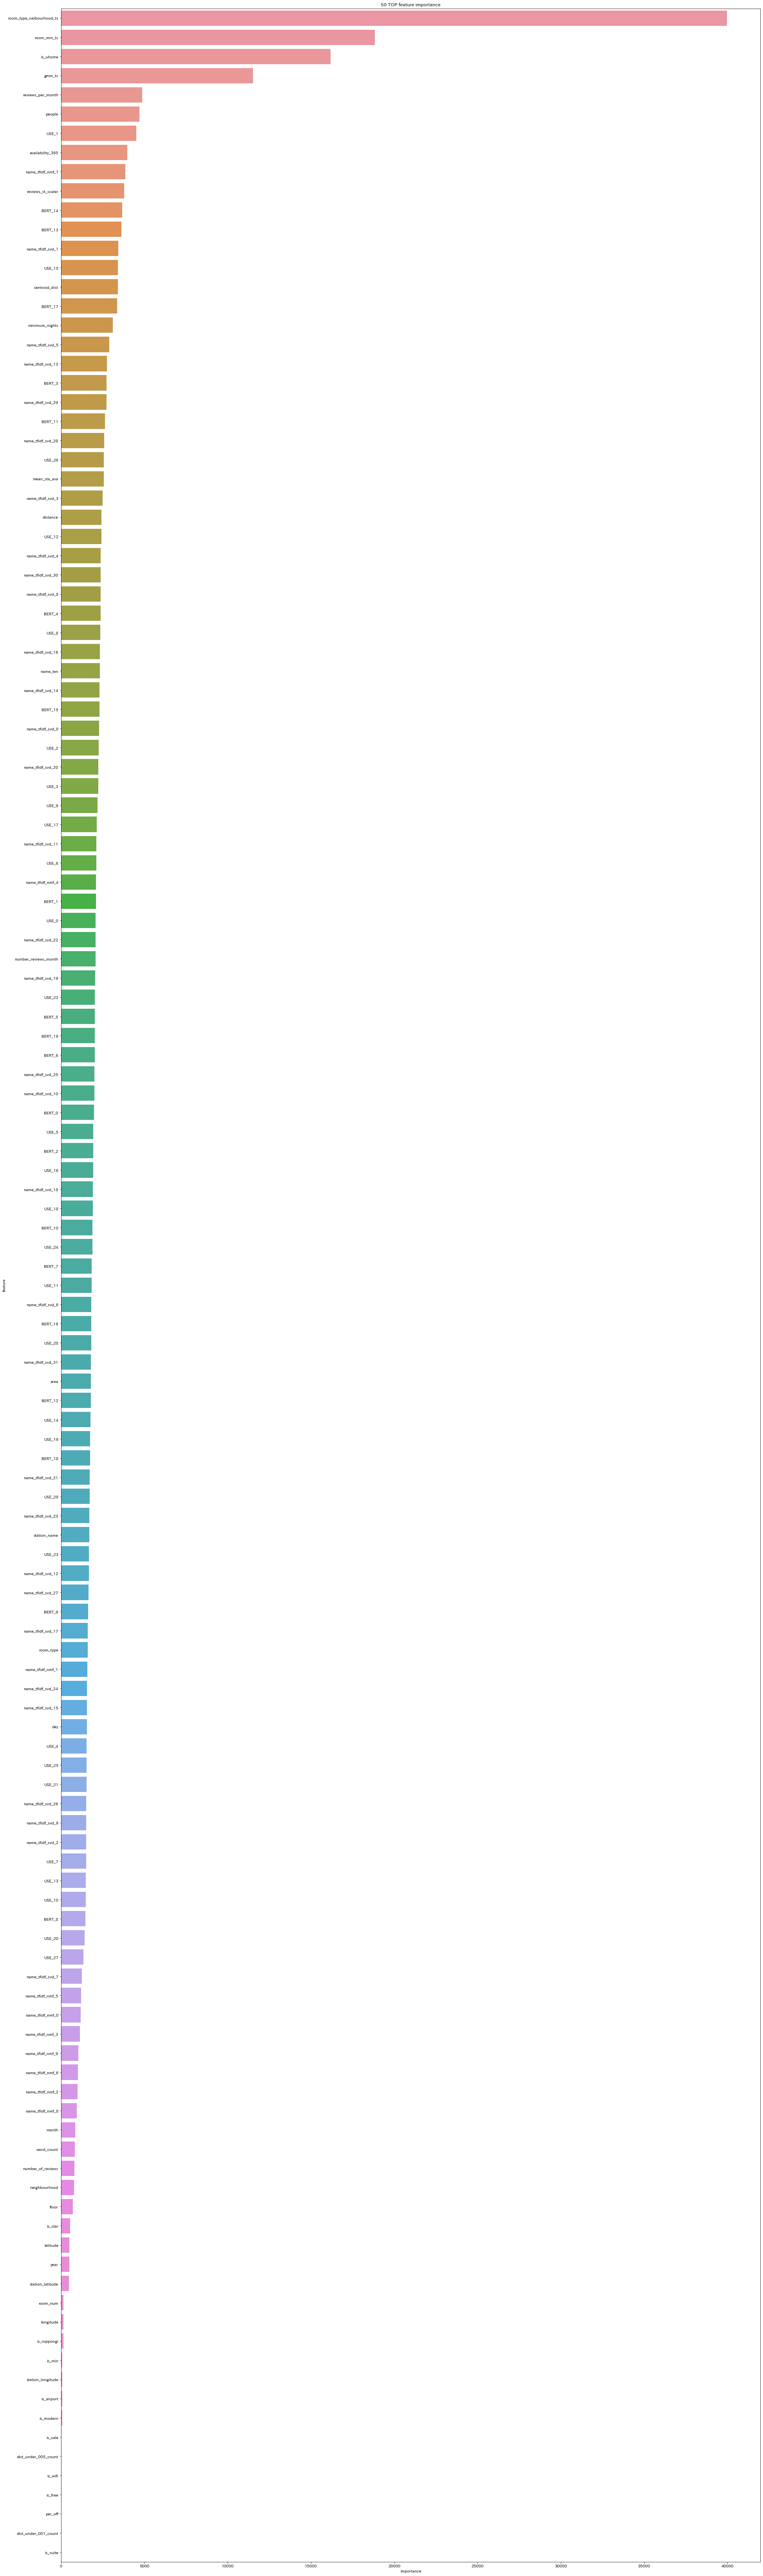

In [106]:
%%time
# 回帰予測用のlightgbmモデルを設定
gbm_model1 = create_lightgbm()

base1 = pd.DataFrame(columns=['id', 'pred'])
test_scores1 = np.nan

FOLD = 5
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X, neighbourhood)):

# kf = StratifiedGroupKFold(n_splits=FOLD, random_state=SEED, shuffle=True)
# for fold, (train_indices, valid_indices) in enumerate(kf.split(X, X['station_name'], host_id)):

    print('======================={}======================='.format(fold))
    train_data_x, valid_data_x = X.iloc[train_indices], X.iloc[valid_indices]
    train_data_y, valid_data_y = Y.iloc[train_indices], Y.iloc[valid_indices]
    print('train shape {}'.format(train_data_x.drop(['id'], axis=1).shape))

    # モデルの学習
    gbm_model1.fit(train_data_x.drop(['id'], axis=1), 
                train_data_y,
                eval_set=[(valid_data_x.drop(['id'], axis=1), valid_data_y)],
                eval_metric='RMSE',
                early_stopping_rounds=100,
                verbose = 500)

    # 予測
    gbm_pred_log = gbm_model1.predict(valid_data_x.drop(['id'], axis=1))

    # 比較用のDF作成
    comparison_gbm_df = pd.concat([valid_data_x, valid_data_y], axis=1)
    comparison_gbm_df['pred_ori'] = gbm_pred_log
    comparison_gbm_df['y_ori'] = comparison_gbm_df['y']
    comparison_gbm_df['pred'] = gbm_pred_log
    comparison_gbm_df['pred'] = np.round(np.exp(comparison_gbm_df['pred']), 0)
    comparison_gbm_df['y'] = np.round(np.exp(comparison_gbm_df['y']), 0)

    # RMSLE
    gbm_RMSE = np.sqrt(mean_squared_error(comparison_gbm_df['y_ori'], comparison_gbm_df['pred_ori']))
    print('RMSE : {}'.format(gbm_RMSE))

    base1 = base1.append(comparison_gbm_df[['id', 'pred']])

    # 予測
    pred_test = gbm_model1.predict(test)

    if fold == 0:

        # 説明変数の重要度を格納するためのデータフレームを作成
        feature_importances = pd.DataFrame()
        feature_importances['feature'] = train_data_x.drop(['id'], axis=1).columns
        feature_importances['importance'] = gbm_model1.feature_importances_

        # 重要度が大きい順に可視化
        plt.figure(figsize=(32, 120))
        sns.barplot(data=feature_importances.sort_values('importance', ascending=False),
                    x='importance',
                    y='feature')
        plt.title('50 TOP feature importance')

        test_scores1 = pred_test
        RMSE1 = gbm_RMSE
        
    else:
        test_scores1 += pred_test
        RMSE1 += gbm_RMSE

### LightGBM(StratifiedGroupKFold)

=======================0=======================
train shape (7750, 133)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 0.878705	valid_0's l2: 0.772123
[400]	valid_0's rmse: 0.873821	valid_0's l2: 0.763563
Early stopping, best iteration is:
[424]	valid_0's rmse: 0.873252	valid_0's l2: 0.762568
RMSE : 0.8732515041228974
=======================1=======================
train shape (8270, 133)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 0.687203	valid_0's l2: 0.472248
[400]	valid_0's rmse: 0.670825	valid_0's l2: 0.450007
[600]	valid_0's rmse: 0.666214	valid_0's l2: 0.443841
[800]	valid_0's rmse: 0.664197	valid_0's l2: 0.441157
[1000]	valid_0's rmse: 0.663513	valid_0's l2: 0.440249
[1200]	valid_0's rmse: 0.662999	valid_0's l2: 0.439568
[1400]	valid_0's rmse: 0.662521	valid_0's l2: 0.438934
Early stopping, best iteration is:
[1479]	valid_0's rmse: 0.662178	valid_0's l2: 0.43848
RMSE : 0.6621778943213511
===========

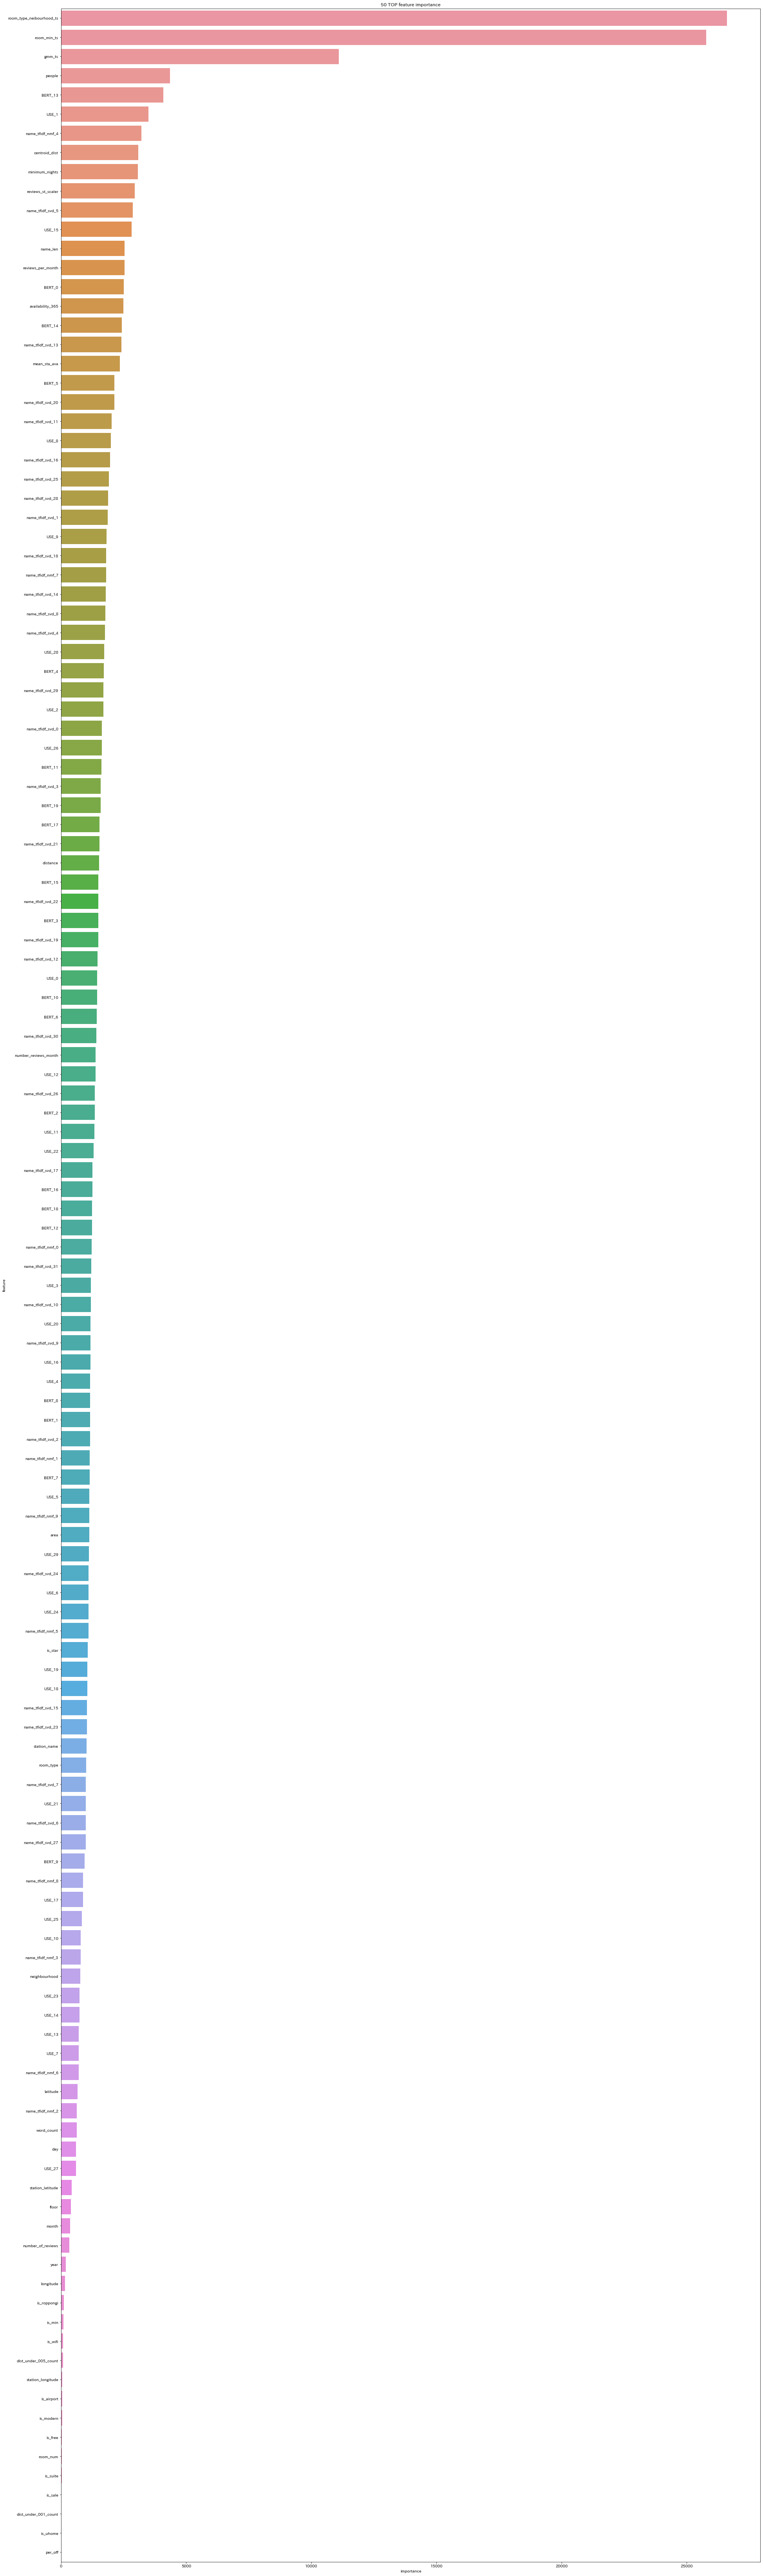

In [107]:
%%time
# 回帰予測用のlightgbmモデルを設定
gbm_model2 = create_lightgbm()
base2 = pd.DataFrame(columns=['id', 'pred'])
test_scores2 = np.nan

FOLD = 5

kf = StratifiedGroupKFold(n_splits=FOLD, random_state=SEED, shuffle=True)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X, X['station_name'], host_id)):

    print('======================={}======================='.format(fold))
    train_data_x, valid_data_x = X.iloc[train_indices], X.iloc[valid_indices]
    train_data_y, valid_data_y = Y.iloc[train_indices], Y.iloc[valid_indices]
    print('train shape {}'.format(train_data_x.drop(['id'], axis=1).shape))

    # モデルの学習
    gbm_model2.fit(train_data_x.drop(['id'], axis=1), 
                train_data_y,
                eval_set=[(valid_data_x.drop(['id'], axis=1), valid_data_y)],
                eval_metric='RMSE',
                early_stopping_rounds=100,
                verbose = 200)

    # 予測
    gbm_pred_log = gbm_model2.predict(valid_data_x.drop(['id'], axis=1))

    # 比較用のDF作成
    comparison_gbm_df = pd.concat([valid_data_x, valid_data_y], axis=1)
    comparison_gbm_df['pred_ori'] = gbm_pred_log
    comparison_gbm_df['y_ori'] = comparison_gbm_df['y']
    comparison_gbm_df['pred'] = gbm_pred_log
    comparison_gbm_df['pred'] = np.round(np.exp(comparison_gbm_df['pred']), 0)
    comparison_gbm_df['y'] = np.round(np.exp(comparison_gbm_df['y']), 0)

    # RMSLE
    gbm_RMSE = np.sqrt(mean_squared_error(comparison_gbm_df['y_ori'], comparison_gbm_df['pred_ori']))
    print('RMSE : {}'.format(gbm_RMSE))

    base2 = base2.append(comparison_gbm_df[['id', 'pred']])

    # 予測
    pred_test = gbm_model2.predict(test)

    if fold == 0:

        # 説明変数の重要度を格納するためのデータフレームを作成
        feature_importances = pd.DataFrame()
        feature_importances['feature'] = train_data_x.drop(['id'], axis=1).columns
        feature_importances['importance'] = gbm_model2.feature_importances_

        # 重要度が大きい順に可視化
        plt.figure(figsize=(32, 120))
        sns.barplot(data=feature_importances.sort_values('importance', ascending=False),
                    x='importance',
                    y='feature')
        plt.title('50 TOP feature importance')

        test_scores2 = pred_test
        RMSE2 = gbm_RMSE
        
    else:
        test_scores2 += pred_test
        RMSE2 += gbm_RMSE



### Ridge

In [108]:
%%time
# 回帰予測用のlightgbmモデルを設定
gbm_model3 = Ridge(random_state=SEED)
base3 = pd.DataFrame(columns=['id', 'pred'])
test_scores3 = np.nan

FOLD = 5

kf = StratifiedGroupKFold(n_splits=FOLD, random_state=SEED, shuffle=True)
for fold, (train_indices, valid_indices) in enumerate(kf.split(sc_train, X['station_name'], host_id)):

    print('======================={}======================='.format(fold))
    train_data_x, valid_data_x = sc_train.iloc[train_indices], sc_train.iloc[valid_indices]
    train_data_y, valid_data_y = sc_Y.iloc[train_indices], sc_Y.iloc[valid_indices]
    print('train shape {}'.format(train_data_x.drop(['id'], axis=1).shape))

    # モデルの学習
    gbm_model3.fit(train_data_x.drop(['id'], axis=1), train_data_y)

    # 予測
    gbm_pred_log = gbm_model3.predict(valid_data_x.drop(['id'], axis=1))

    # 比較用のDF作成
    comparison_gbm_df = pd.concat([valid_data_x, valid_data_y], axis=1)
    comparison_gbm_df['pred_ori'] = gbm_pred_log
    comparison_gbm_df['y_ori'] = comparison_gbm_df['y']
    comparison_gbm_df['pred'] = gbm_pred_log
    comparison_gbm_df['pred'] = np.round(np.exp(comparison_gbm_df['pred']), 0)
    comparison_gbm_df['y'] = np.round(np.exp(comparison_gbm_df['y']), 0)

    # RMSLE
    gbm_RMSE = np.sqrt(mean_squared_error(comparison_gbm_df['y_ori'], comparison_gbm_df['pred_ori']))
    print('RMSE : {}'.format(gbm_RMSE))

    base3 = base3.append(comparison_gbm_df[['id', 'pred']])

    # 予測
    pred_test = gbm_model3.predict(sc_test)

    if fold == 0:

        # # 説明変数の重要度を格納するためのデータフレームを作成
        # feature_importances = pd.DataFrame()
        # feature_importances['feature'] = train_data_x.drop(['id'], axis=1).columns
        # feature_importances['importance'] = gbm_model3.feature_importances_

        # # 重要度が大きい順に可視化
        # plt.figure(figsize=(32, 120))
        # sns.barplot(data=feature_importances.sort_values('importance', ascending=False),
        #             x='importance',
        #             y='feature')
        # plt.title('50 TOP feature importance')

        test_scores3 = pred_test
        RMSE3 = gbm_RMSE
        
    else:
        test_scores3 += pred_test
        RMSE3 += gbm_RMSE



=======================0=======================
train shape (7750, 133)
RMSE : 0.8079982399940491
=======================1=======================
train shape (8270, 133)
RMSE : 0.707259476184845
=======================2=======================
train shape (8082, 133)
RMSE : 0.9205834269523621
=======================3=======================
train shape (7929, 133)
RMSE : 0.7813818454742432
=======================4=======================
train shape (7925, 133)
RMSE : 0.7571811676025391
CPU times: user 1.25 s, sys: 250 ms, total: 1.5 s
Wall time: 1.24 s


### Random Forest

In [109]:
%%time
# 回帰予測用のlightgbmモデルを設定
gbm_model4 = RandomForestRegressor(random_state=SEED, n_estimators=100)
base4 = pd.DataFrame(columns=['id', 'pred'])
test_scores4 = np.nan

FOLD = 5

kf = StratifiedGroupKFold(n_splits=FOLD, random_state=SEED, shuffle=True)
for fold, (train_indices, valid_indices) in enumerate(kf.split(sc_train, X['station_name'], host_id)):

    print('======================={}======================='.format(fold))
    train_data_x, valid_data_x = sc_train.iloc[train_indices], sc_train.iloc[valid_indices]
    train_data_y, valid_data_y = sc_Y.iloc[train_indices], sc_Y.iloc[valid_indices]
    print('train shape {}'.format(train_data_x.drop(['id'], axis=1).shape))

    # モデルの学習
    gbm_model4.fit(train_data_x.drop(['id'], axis=1), train_data_y)

    # 予測
    gbm_pred_log = gbm_model4.predict(valid_data_x.drop(['id'], axis=1))

    # 比較用のDF作成
    comparison_gbm_df = pd.concat([valid_data_x, valid_data_y], axis=1)
    comparison_gbm_df['pred_ori'] = gbm_pred_log
    comparison_gbm_df['y_ori'] = comparison_gbm_df['y']
    comparison_gbm_df['pred'] = gbm_pred_log
    comparison_gbm_df['pred'] = np.round(np.exp(comparison_gbm_df['pred']), 0)
    comparison_gbm_df['y'] = np.round(np.exp(comparison_gbm_df['y']), 0)

    # RMSLE
    gbm_RMSE = np.sqrt(mean_squared_error(comparison_gbm_df['y_ori'], comparison_gbm_df['pred_ori']))
    print('RMSE : {}'.format(gbm_RMSE))

    base4 = base4.append(comparison_gbm_df[['id', 'pred']])

    # 予測
    pred_test = gbm_model4.predict(sc_test)

    if fold == 0:

        # # 説明変数の重要度を格納するためのデータフレームを作成
        # feature_importances = pd.DataFrame()
        # feature_importances['feature'] = train_data_x.drop(['id'], axis=1).columns
        # feature_importances['importance'] = gbm_model4.feature_importances_

        # # 重要度が大きい順に可視化
        # plt.figure(figsize=(32, 120))
        # sns.barplot(data=feature_importances.sort_values('importance', ascending=False),
        #             x='importance',
        #             y='feature')
        # plt.title('50 TOP feature importance')

        test_scores4 = pred_test
        RMSE4 = gbm_RMSE
        
    else:
        test_scores4 += pred_test
        RMSE4 += gbm_RMSE



=======================0=======================
train shape (7750, 133)
RMSE : 0.8066822767472476
=======================1=======================
train shape (8270, 133)
RMSE : 0.6910466569906604
=======================2=======================
train shape (8082, 133)
RMSE : 0.9307971142336194
=======================3=======================
train shape (7929, 133)
RMSE : 0.7537485459361626
=======================4=======================
train shape (7925, 133)
RMSE : 0.7185617523015493
CPU times: user 6min 23s, sys: 340 ms, total: 6min 23s
Wall time: 6min 22s


### Adaboost

In [110]:
%%time

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

gbm_model5 = AdaBoostRegressor(DecisionTreeRegressor(random_state=SEED, max_depth=None), random_state=SEED, n_estimators=50)

base5 = pd.DataFrame(columns=['id', 'pred'])
# 回帰予測用のlightgbmモデルを設定
# gbm_model5 = MLPRegressor(hidden_layer_sizes=(100,100,100,100,),random_state=SEED)

test_scores5 = np.nan

FOLD = 5

kf = StratifiedGroupKFold(n_splits=FOLD, random_state=SEED, shuffle=True)
for fold, (train_indices, valid_indices) in enumerate(kf.split(sc_train, X['station_name'], host_id)):

    print('======================={}======================='.format(fold))
    train_data_x, valid_data_x = sc_train.iloc[train_indices], sc_train.iloc[valid_indices]
    train_data_y, valid_data_y = sc_Y.iloc[train_indices], sc_Y.iloc[valid_indices]
    print('train shape {}'.format(train_data_x.drop(['id'], axis=1).shape))

    # モデルの学習
    gbm_model5.fit(train_data_x.drop(['id'], axis=1), train_data_y)

    # 予測
    gbm_pred_log = gbm_model5.predict(valid_data_x.drop(['id'], axis=1))

    # 比較用のDF作成
    comparison_gbm_df = pd.concat([valid_data_x, valid_data_y], axis=1)
    comparison_gbm_df['pred_ori'] = gbm_pred_log
    comparison_gbm_df['y_ori'] = comparison_gbm_df['y']
    comparison_gbm_df['pred'] = gbm_pred_log
    comparison_gbm_df['pred'] = np.round(np.exp(comparison_gbm_df['pred']), 0)
    comparison_gbm_df['y'] = np.round(np.exp(comparison_gbm_df['y']), 0)

    # RMSLE
    gbm_RMSE = np.sqrt(mean_squared_error(comparison_gbm_df['y_ori'], comparison_gbm_df['pred_ori']))
    print('RMSE : {}'.format(gbm_RMSE))

    base5 = base5.append(comparison_gbm_df[['id', 'pred']])


    # 予測
    pred_test = gbm_model5.predict(sc_test)

    if fold == 0:

        # # 説明変数の重要度を格納するためのデータフレームを作成
        # feature_importances = pd.DataFrame()
        # feature_importances['feature'] = train_data_x.drop(['id'], axis=1).columns
        # feature_importances['importance'] = gbm_model5.feature_importances_

        # # 重要度が大きい順に可視化
        # plt.figure(figsize=(32, 120))
        # sns.barplot(data=feature_importances.sort_values('importance', ascending=False),
        #             x='importance',
        #             y='feature')
        # plt.title('50 TOP feature importance')

        test_scores5 = pred_test
        RMSE5 = gbm_RMSE
        
    else:
        test_scores5 += pred_test
        RMSE5 += gbm_RMSE

=======================0=======================
train shape (7750, 133)
RMSE : 0.8459949826033057
=======================1=======================
train shape (8270, 133)
RMSE : 0.6838190567164961
=======================2=======================
train shape (8082, 133)
RMSE : 0.9270894487081136
=======================3=======================
train shape (7929, 133)
RMSE : 0.7727828964225487
=======================4=======================
train shape (7925, 133)
RMSE : 0.705956801440613
CPU times: user 4min 7s, sys: 190 ms, total: 4min 7s
Wall time: 4min 6s


In [111]:
print('oof RMSE1 : {}'.format(RMSE1 / FOLD))
print('oof RMSE2 : {}'.format(RMSE2 / FOLD))
print('oof RMSE3 : {}'.format(RMSE3 / FOLD))
print('oof RMSE4 : {}'.format(RMSE4 / FOLD))
print('oof RMSE5 : {}'.format(RMSE5 / FOLD))

oof RMSE1 : 0.5129298009845171
oof RMSE2 : 0.7749058272674862
oof RMSE3 : 0.7948808193206787
oof RMSE4 : 0.7801672692418478
oof RMSE5 : 0.7871286371782155


## 2層目

In [112]:
base1

,id,pred
0,1,10823.0
5,6,8702.0
7,8,15326.0
19,20,3191.0
21,22,18780.0
...,...,...
9962,9964,12373.0
9965,9967,14214.0
9971,9973,11183.0
9975,9977,21796.0


In [148]:
b2 = base2.copy()
b3 = base3.copy()
b4 = base4.copy()
b5 = base5.copy()

b2.rename(columns = {"pred":"pred2"}, inplace = True)
b3.rename(columns = {"pred":"pred3"}, inplace = True)
b4.rename(columns = {"pred":"pred4"}, inplace = True)
b5.rename(columns = {"pred":"pred5"}, inplace = True)

b2['pred2'] = np.log(b2['pred2'])
b3['pred3'] = np.log(b3['pred3'])
b4['pred4'] = np.log(b4['pred4'])
b5['pred5'] = np.log(b5['pred5'])

base = pd.merge(base1, b2, on='id', how='left')
base = pd.merge(base, b3, on='id', how='left')
base = pd.merge(base, b4, on='id', how='left')
base = pd.merge(base, b5, on='id', how='left')

base = pd.merge(base, train[['id', 'y']], on='id', how='left')

In [149]:
base

,id,pred,pred2,pred3,pred4,pred5,y
0,1,10823.0,9.531554,9.747944,9.785042,9.789086,9.390625
1,6,8702.0,10.232000,9.968573,10.038630,10.468745,9.039062
2,8,15326.0,9.238247,9.433244,9.286282,9.195328,9.898438
3,20,3191.0,8.422663,8.257645,8.327726,8.515592,8.132812
4,22,18780.0,9.509407,9.412791,9.471704,9.414097,9.835938
...,...,...,...,...,...,...,...
9984,9964,12373.0,9.531626,9.545883,9.508740,9.390660,9.203125
9985,9967,14214.0,9.598524,9.608042,9.568015,9.390660,9.984375
9986,9973,11183.0,9.185228,9.042276,9.368284,9.085910,8.726562
9987,9977,21796.0,9.618402,8.944289,9.706864,10.312513,10.125000


In [150]:
base_X = base.drop(['id', 'y'], axis=1)
base_Y = base['y']

In [151]:
confirm_test = pd.read_csv(INPUT + 'test_data.csv')
base_test = confirm_test.copy()


base_test['pred'] = test_scores1 / FOLD
base_test['pred2'] = test_scores2 / FOLD
base_test['pred3'] = test_scores3 / FOLD
base_test['pred4'] = test_scores4 / FOLD
base_test['pred5'] = test_scores5 / FOLD

base_test = base_test[['pred', 'pred2', 'pred3', 'pred4', 'pred5']]

# base_test = base_test[['pred', 'pred2', 'pred3', 'pred5']]
base_test.head()

,pred,pred2,pred3,pred4,pred5
0,9.306951,9.394088,9.363370,9.418039,9.285937
1,9.928369,9.656403,9.175335,9.640703,9.421875
2,9.618459,9.502561,9.415568,9.558641,9.565625
3,9.503944,9.475762,9.317559,9.381234,9.451562
4,9.490388,9.478139,9.325248,9.508031,9.393750


In [117]:
base_test.isnull().sum()

pred     0
pred2    0
pred3    0
pred4    0
pred5    0
dtype: int64

In [154]:
# 回帰予測用のlightgbmモデルを設定
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

# em_model = Ridge(random_state=SEED)
em_model = GradientBoostingRegressor(random_state=SEED, verbose=1, max_depth=4)
test_scores_em = np.nan

FOLD = 5

kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(base_X, base_Y)):

    print('======================={}======================='.format(fold))
    train_data_x, valid_data_x = base_X.iloc[train_indices], base_X.iloc[valid_indices]
    train_data_y, valid_data_y = base_Y.iloc[train_indices], base_Y.iloc[valid_indices]
    print('train shape {}'.format(train_data_x.shape))

    # モデルの学習
    em_model.fit(train_data_x, train_data_y)

    # 予測
    gbm_pred_log = em_model.predict(valid_data_x)

    # 比較用のDF作成
    comparison_gbm_df = pd.concat([valid_data_x, valid_data_y], axis=1)
    comparison_gbm_df['pred_ori'] = gbm_pred_log
    comparison_gbm_df['y_ori'] = comparison_gbm_df['y']
    comparison_gbm_df['pred'] = gbm_pred_log
    comparison_gbm_df['pred'] = np.round(np.exp(comparison_gbm_df['pred']), 0)
    comparison_gbm_df['y'] = np.round(np.exp(comparison_gbm_df['y']), 0)

    # RMSLE
    gbm_RMSE = np.sqrt(mean_squared_error(comparison_gbm_df['y_ori'], comparison_gbm_df['pred_ori']))
    print('RMSE : {}'.format(gbm_RMSE))


    # 予測
    pred_test = em_model.predict(base_test)

    if fold == 0:

        # # 説明変数の重要度を格納するためのデータフレームを作成
        # feature_importances = pd.DataFrame()
        # feature_importances['feature'] = train_data_x.columns
        # feature_importances['importance'] = em_model.feature_importances_

        # # 重要度が大きい順に可視化
        # plt.figure(figsize=(32, 120))
        # sns.barplot(data=feature_importances.sort_values('importance', ascending=False),
        #             x='importance',
        #             y='feature')
        # plt.title('50 TOP feature importance')

        test_scores_em = pred_test
        RMSE_em = gbm_RMSE
        
    else:
        test_scores_em += pred_test
        RMSE_em += gbm_RMSE



=======================0=======================
train shape (7991, 5)
      Iter       Train Loss   Remaining Time 
         1           0.8278            2.03s
         2           0.7196            2.50s
         3           0.6319            2.32s
         4           0.5607            2.21s
         5           0.5030            2.19s
         6           0.4559            2.21s
         7           0.4178            2.17s
         8           0.3865            2.12s
         9           0.3606            2.13s
        10           0.3399            2.08s
        20           0.2556            1.79s
        30           0.2392            1.54s
        40           0.2332            1.32s
        50           0.2289            1.10s
        60           0.2249            0.90s
        70           0.2213            0.67s
        80           0.2175            0.45s
        90           0.2139            0.22s
       100           0.2106            0.00s
RMSE : 0.5064964514571157
===

In [155]:
print(RMSE1 / FOLD)
print(RMSE2 / FOLD)
print(RMSE3 / FOLD)
print(RMSE4 / fold)
print(RMSE5 / FOLD)
print(RMSE_em / FOLD)

0.5129298009845171
0.7749058272674862
0.7948808193206787
0.9752090865523098
0.7871286371782155
0.5060720607056276


oof RMSE1 : 0.5189969904506913
oof RMSE2 : 0.7766986062312181

In [120]:
# ax = lgb.plot_tree(gbm_model, tree_index=0, figsize=(200, 200), show_info=['split_gain'])
# plt.show()

# graph = lgb.create_tree_digraph(gbm_model, tree_index=0, format='png', name='Tree')

# with open(OUTPUT + 'Tree.png', 'w') as f:
#     f.write(graph.render(view=True))

In [121]:
# # 比較結果を散布図で表示
# plt.figure(figsize=(20, 6))
# comparison_gbm_df.plot.scatter(x="y_ori",y="pred_ori")
# plt.plot(np.arange(15),np.arange(15),color="r")
# plt.xlim([5,15])
# plt.ylim([5,15])
# plt.show()

In [122]:
# plt.figure(figsize=(20, 6))
# sns.distplot(comparison_gbm_df['y_ori'], label='true')
# sns.distplot(comparison_gbm_df['pred_ori'], label='pred')
# plt.legend()

In [123]:
# plt.figure(figsize=(10, 6))
# plt.plot(comparison_gbm_df.sort_values('y_ori')['y_ori'].reset_index()['y_ori'])
# plt.plot(comparison_gbm_df.sort_values('pred_ori')['pred_ori'].reset_index()['pred_ori'])

## 提出

In [124]:
confirm_test = pd.read_csv(INPUT + 'test_data.csv')

# 提出用ファイルの作成
submission = confirm_test.copy()
submission['y'] = np.round(np.exp(((test_scores1 / FOLD * 0.3) + (test_scores2 / FOLD * 0.3) + (test_scores3 / FOLD * 0.1) + (test_scores4 / FOLD * 0.2) + (test_scores5 / FOLD * 0.1))), 0)
submission.loc[submission['name'].str.contains('Uhome'), 'y'] = (submission['y'] + uhome_mean) / 2
submission = submission[['id', 'y']]

In [125]:
submission.to_csv(OUTPUT + '/sub01.csv', index=False)

In [126]:
submission.shape

(4996, 2)

In [156]:
confirm_test = pd.read_csv(INPUT + 'test_data.csv')

# 提出用ファイルの作成
submission = confirm_test.copy()
submission['y'] = np.round(np.exp(test_scores_em / FOLD), 0)
submission.loc[submission['name'].str.contains('Uhome'), 'y'] = (submission['y'] + uhome_mean) / 2
submission = submission[['id', 'y']]

In [157]:
submission.to_csv(OUTPUT + '/em_sub01.csv', index=False)